# BYOL
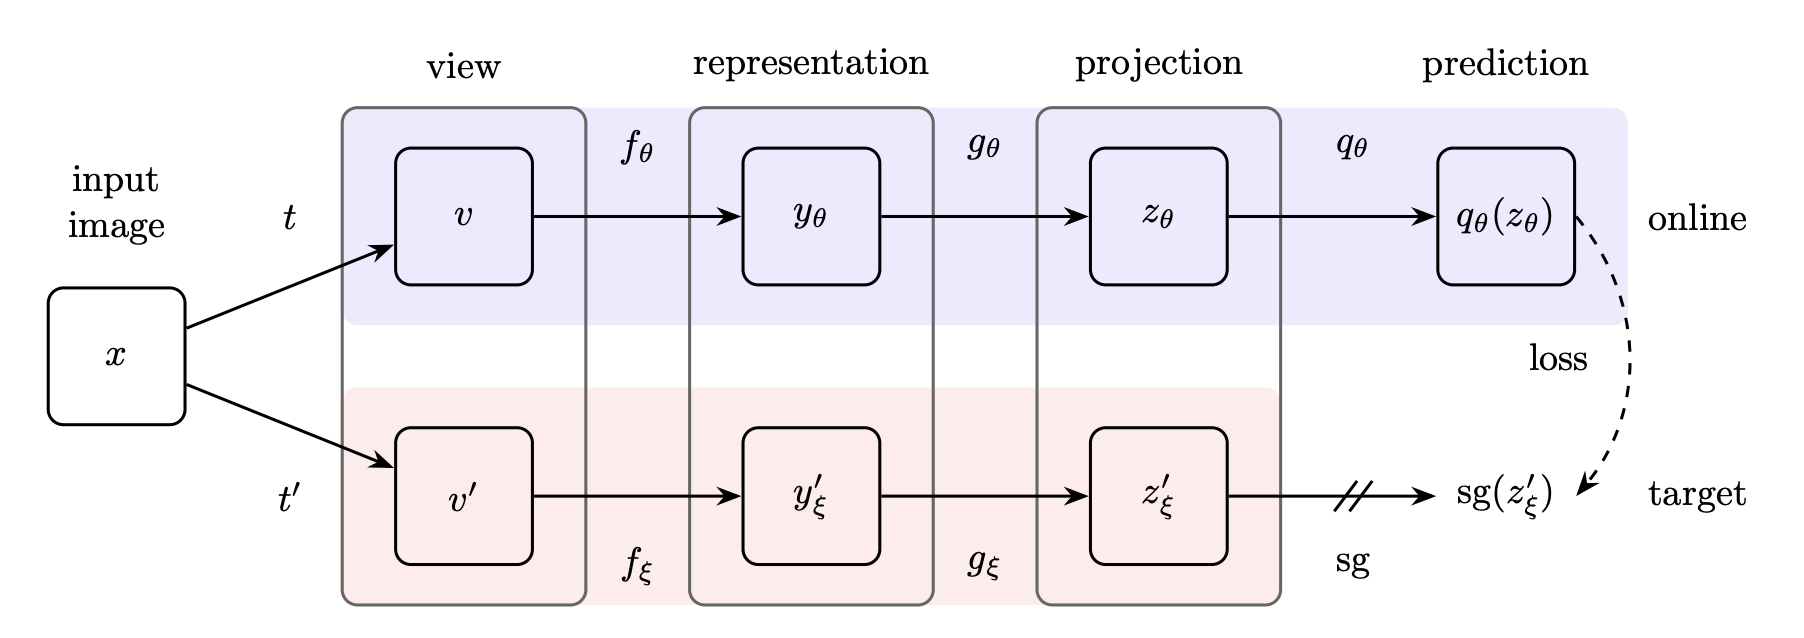

In this notebook we are going to implement [BYOL: Bootstrap Your Own Latent](https://arxiv.org/pdf/2006.07733.pdf) and compare the results of a classification task before and after pretraining the model with BYOL.

### Data Augmentations

In [1]:
import random
from typing import Callable, Tuple

import torch
import torchvision
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor

In [2]:
class RandomApply(nn.Module):
    def __init__(self, fn: Callable, p: float):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        if random.random() < self.p:
            x = self.fn(x)
        return x


def default_augmentation(image_size: Tuple[int, int] = (96, 96)):
    return T.Compose([
        RandomApply(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1), p=0.8),
        RandomApply(T.Grayscale(num_output_channels=3), p=0.2),
        RandomApply(T.RandomHorizontalFlip(p=0.5), p=0.8),
        RandomApply(T.GaussianBlur(kernel_size=(3, 3), sigma=(1.5, 1.5)), p=0.2),
        RandomApply(T.RandomResizedCrop(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)), p=0.5),
        T.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        ),
    ])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Model
We will use ResNet18 as our representation model.

In [4]:
def get_encoder_model(**kwargs):
    resnet = torchvision.models.resnet18(**kwargs)
    return torch.nn.Sequential(*list(resnet.children())[:-1])

### Loss Function
We need to use NormalizedMSELoss as our loss function.
$$NormalizedMSELoss(v_1, v_2) = \Vert \bar{v_1} - \bar{v_2}\Vert_2^2 = 2 - 2.\frac{\langle v_1, v_2 \rangle}{\Vert v_1\Vert_2 \Vert v_2\Vert_2}$$

In [5]:
class NormalizedMSELoss(nn.Module):
    def __init__(self) -> None:
        super(NormalizedMSELoss,self).__init__()

    def forward(self, view1: Tensor, view2: Tensor) -> Tensor:
        v1 = F.normalize(view1, dim=-1)
        v2 = F.normalize(view2, dim=-1)
        return 2 - 2 * (v1 * v2).sum(dim=-1)

### MLP
Here you will implement a simple MLP class with one hidden layer with BatchNorm and ReLU activation, and a linear output layer. This class will be used for both the projections and the prediction networks.

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, projection_dim: int=128, hidden_dim: int=512) -> None:
        super(MLP,self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)

### Encoder + Projector Network
This is the network structure that is shared between online and target networks. It consists of our encoder model, followed by a projection MLP.

In [7]:
class EncoderProjecter(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 hidden_dim: int=512,
                 projection_out_dim: int=128
                 ) -> None:
        super(EncoderProjecter, self).__init__()

        self.encoder = encoder
        self.projetion = MLP(input_dim=512, projection_dim=projection_out_dim, hidden_dim=hidden_dim)

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        return self.projetion(h)

## BYOL

In [8]:
class BYOL(nn.Module):
    def __init__(self,
                 hidden_dim: int = 512,
                 projection_out_dim: int = 128,
                 target_decay: float = 0.996
                ) -> None:
        super(BYOL, self).__init__()
        resnet = get_encoder_model()
        self.online_network = EncoderProjecter(resnet)  # encoder + projector
        self.online_predictor = MLP(input_dim=projection_out_dim, projection_dim=projection_out_dim, hidden_dim=hidden_dim)

        self.target_network = EncoderProjecter(resnet)  # init with copy of parameters of online network
        self.target_network.load_state_dict(self.online_network.state_dict())
        
        # set target_network's weights to be untrainable
        self.target_network.eval()
        for param in self.target_network.parameters():
            param.requires_grad = False
        self.target_decay = target_decay
        self.loss_function = NormalizedMSELoss()


    @torch.no_grad()
    def soft_update_target_network(self) -> None:
        for online_p, target_p in zip(self.online_network.parameters(), self.target_network.parameters()):
            target_p.data = target_p.data * self.target_decay + online_p.data * (1. - self.target_decay)


    def forward(self, view) -> Tuple[Tensor]:
        online_proj = self.online_network(view)
        target_proj = self.target_network(view)

        return online_proj, target_proj

    def loss(self, view1, view2):
        online_proj1, target_proj1 = self(view1)
        online_proj2, target_proj2 = self(view2)

        online_prediction_1 = self.online_predictor(online_proj1)
        online_prediction_2 = self.online_predictor(online_proj2)

        loss1 = self.loss_function(online_prediction_1, target_proj2.detach())
        loss2 = self.loss_function(online_prediction_2, target_proj1.detach())
        return torch.mean(loss1 + loss2)

# STL10 Datasets

We need 3 separate datasets from STL10 for this experiment:
1. `"train"` -- Contains only labeled training images. Used for supervised training.
2. `"train+unlabeled"` -- Contains training images, plus a large number of unlabelled images.  Used for self-supervised learning with BYOL.
3. `"test"` -- Labeled test images.  We use it both as a validation set, and for computing the final model accuracy.

In [8]:
TRAIN_DATASET = STL10(root="data", split="train", download=True, transform=ToTensor())
TRAIN_UNLABELED_DATASET = STL10(root="data", split="train+unlabeled", download=True, transform=ToTensor())
TEST_DATASET = STL10(root="data", split="test", download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Create dataloaders:

In [28]:
LABELED_BATCH_SIZE = 128
UNLABELED_BATCH_SIZE = 1024

train_dataloader = DataLoader(TRAIN_DATASET, batch_size=LABELED_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
train_unlabeled_dataloader = DataLoader(TRAIN_UNLABELED_DATASET, batch_size=UNLABELED_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(TEST_DATASET, batch_size=LABELED_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Supervised Training without BYOL

First create a classifier model by simply adding a linear layer on top of the encoder model. Then train the model using the labeled training set. Performance should be pretty good already.

In [9]:
class Classifier(nn.Module):
    def __init__(self, encoder_model):
        super(Classifier, self).__init__()
        self.encoder = encoder_model
        self.fc = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        return x

In [17]:
encoder = get_encoder_model(pretrained=True)
classifier = Classifier(encoder)
classifier.to(device)

Classifier(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [10]:
def train_supervised(model, dataloader, num_epochs=40):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step(running_loss)

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

    return model

In [19]:
classifier = train_supervised(classifier, train_dataloader, num_epochs=25)

Epoch 1/25 - Loss: 0.7753
Epoch 2/25 - Loss: 0.3231
Epoch 3/25 - Loss: 0.2987
Epoch 4/25 - Loss: 0.2937
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/25 - Loss: 0.2914
Epoch 6/25 - Loss: 0.1057
Epoch 7/25 - Loss: 0.0441
Epoch 8/25 - Loss: 0.0262
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 9/25 - Loss: 0.0234
Epoch 10/25 - Loss: 0.0188
Epoch 11/25 - Loss: 0.0118
Epoch 12/25 - Loss: 0.0224
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Epoch 13/25 - Loss: 0.0109
Epoch 14/25 - Loss: 0.0159
Epoch 15/25 - Loss: 0.0104
Epoch 16/25 - Loss: 0.0107
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.
Epoch 17/25 - Loss: 0.0106
Epoch 18/25 - Loss: 0.0093
Epoch 19/25 - Loss: 0.0110
Epoch 20/25 - Loss: 0.0113
Epoch 00021: reducing learning rate of group 0 to 1.0000e-08.
Epoch 21/25 - Loss: 0.0128
Epoch 22/25 - Loss: 0.0342
Epoch 23/25 - Loss: 0.0092
Epoch 24/25 - Loss: 0.0254
Epoch 25/25 - Loss: 0.0116


In [11]:
def evaluate_supervised(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    return accuracy

In [21]:
supervised_accuracy = evaluate_supervised(classifier, test_dataloader)
print(f"Accuracy on the test set for supervised learning: {supervised_accuracy:.2f}%")

Accuracy on the test set for supervised learning: 84.58%


### Self-Supervised Training with BYOL

Now perform the self-supervised training. This is the most computationally intensive part of the script.

In [12]:
def train_self_supervised(model, dataloader, num_epochs=50):
    optimizer = optim.Adam(list(model.online_network.parameters()) + list(model.online_predictor.parameters()), lr=0.0002)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
    augmentor = default_augmentation()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch, _ in dataloader:
            batch = batch.to(device)

            with torch.no_grad():
                view_1, view_2 = augmentor(batch), augmentor(batch)

            loss = model.loss(view_1, view_2)
            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.soft_update_target_network()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

    return model

In [37]:
byol = BYOL()
byol.to(device)

BYOL(
  (online_network): EncoderProjecter(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(

In [38]:
byol = train_self_supervised(byol, train_unlabeled_dataloader, num_epochs=10)

Epoch 1/10 - Loss: 1.1075
Epoch 2/10 - Loss: 0.6287
Epoch 3/10 - Loss: 0.5816
Epoch 4/10 - Loss: 0.5642
Epoch 5/10 - Loss: 0.5420
Epoch 6/10 - Loss: 0.5683
Epoch 7/10 - Loss: 0.5477
Epoch 8/10 - Loss: 0.5135
Epoch 9/10 - Loss: 0.5089
Epoch 10/10 - Loss: 0.4954


### Supervised Training Again

Extract the encoder network's state dictionary from BYOL, and load it into our ResNet18 model before starting training.  Then run supervised training, and watch the accuracy improve from last time!

In [39]:
trained_encoder = get_encoder_model()
trained_encoder.load_state_dict(byol.online_network.encoder.state_dict())

pretrained_classifier = Classifier(trained_encoder)
pretrained_classifiersifier.to(device)
pretrained_classifier = train_supervised(pretrained_classifier, train_dataloader, num_epochs=25)

Epoch 1/25 - Loss: 1.1119
Epoch 2/25 - Loss: 0.2390
Epoch 3/25 - Loss: 0.0682
Epoch 4/25 - Loss: 0.0226
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/25 - Loss: 0.0090
Epoch 6/25 - Loss: 0.0037
Epoch 7/25 - Loss: 0.0026
Epoch 8/25 - Loss: 0.0021
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 9/25 - Loss: 0.0017
Epoch 10/25 - Loss: 0.0015
Epoch 11/25 - Loss: 0.0016
Epoch 12/25 - Loss: 0.0015
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Epoch 13/25 - Loss: 0.0014
Epoch 14/25 - Loss: 0.0015
Epoch 15/25 - Loss: 0.0014
Epoch 16/25 - Loss: 0.0015
Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.
Epoch 17/25 - Loss: 0.0014
Epoch 18/25 - Loss: 0.0015
Epoch 19/25 - Loss: 0.0014
Epoch 20/25 - Loss: 0.0015
Epoch 00021: reducing learning rate of group 0 to 1.0000e-08.
Epoch 21/25 - Loss: 0.0015
Epoch 22/25 - Loss: 0.0014
Epoch 23/25 - Loss: 0.0015
Epoch 24/25 - Loss: 0.0014
Epoch 25/25 - Loss: 0.0014


In [40]:
self_supervised_accuracy = evaluate_supervised(pretrained_classifier, test_dataloader)
print(f"Accuracy on the test set for self-supervised learning: {self_supervised_accuracy:.2f}%")

Accuracy on the test set for self-supervised learning: 87.61%
